In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# Part 2
## Task 7

In [93]:
Q = np.array(
    [[-0.0085, 0.005, 0.0025, 0.0, 0.001],
     [0.0, -0.014, 0.005, 0.004, 0.005],
     [0.0, 0.0, -0.008, 0.003, 0.005],
     [0.0, 0.0, 0.0, -0.009, 0.009],
     [0.0, 0.0, 0.0, 0.0, 0.00]]
)

assert np.allclose(Q.sum(axis=1), 0), "Rows of Q should sum to zero"

P = np.zeros_like(Q)
for i in range(Q.shape[0]):
    if Q[i, i] != 0:
        P[i] = Q[i] / -Q[i, i]
        P[i, i] = 0  # Set diagonal to zero

assert np.allclose(P[:-1].sum(axis=1), 1), "Rows of P should sum to one"

# extract negative diagonal elements for easier indexing
Q_s = Q[:-1, :-1]
q = -1 / np.diag(Q_s)

In [5]:
P, q

(array([[0.        , 0.58823529, 0.29411765, 0.        , 0.11764706],
        [0.        , 0.        , 0.35714286, 0.28571429, 0.35714286],
        [0.        , 0.        , 0.        , 0.375     , 0.625     ],
        [0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([117.64705882,  71.42857143, 125.        , 111.11111111]))

In [6]:
# Sampling time until next transition from state 2
print(np.random.exponential(q[2]))

# Sampling next state from state 2
print(np.random.choice([0, 1, 2, 3, 4], p=P[2]))

60.04925035622064
4


In [103]:

def simulate_breast_cancer(womens: int):
    states = np.zeros(womens, dtype=int)
    sojourns = np.random.exponential(q[0], womens)
    lifetimes = np.zeros(womens)
    alive = np.ones(womens, dtype=bool)

    state_history = []
    times = []
    time = 0.0

    with tqdm(total=womens, desc="Women dead") as pbar:
        while np.any(alive):
            # Skip to next event
            active_indices = np.where(alive)[0]
            event = active_indices[np.argmin(sojourns[alive])]

            elapsed = sojourns[event]
            sojourns[alive] -= elapsed
            lifetimes[event] += elapsed
            time += elapsed
            times.append(time)  # Store time of event

            new_state = np.random.choice(len(Q), p=P[states[event]])
            
            state_history.append(states.copy())
            # state_history.append((times[event], event, states[event], new_state))
            states[event] = new_state

            

            # Kill woman or update state and sojourn time
            if new_state == 4:
                alive[event] = False
                pbar.update(1)
            else:
                sojourns[event] = np.random.exponential(q[new_state])

    return {
        "lifetimes": lifetimes,
        "times": times,
        "state_history": np.array(state_history),
        "time": time,
        }


np.random.seed(23)  # For reproducibility
results = simulate_breast_cancer(1000)

Women dead: 100%|██████████| 1000/1000 [00:00<00:00, 1771.23it/s]


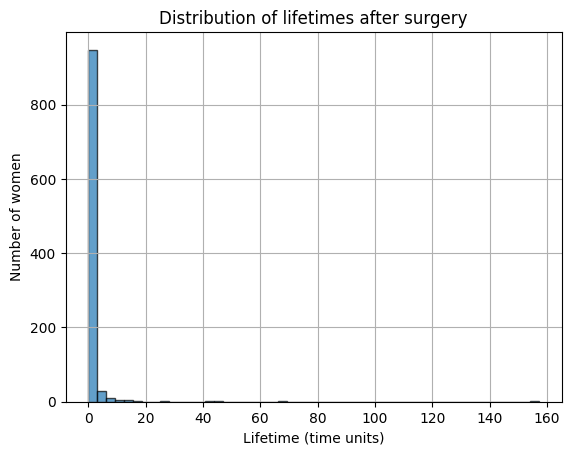

In [104]:
def plot_lifetimes(result_dict):
    lifetimes = result_dict["lifetimes"]
    plt.hist(lifetimes, bins=50, edgecolor='k', alpha=0.7)
    plt.xlabel("Lifetime (time units)")
    plt.ylabel("Number of women")
    # plt.xlim([0, 50])
    plt.title("Distribution of lifetimes after surgery")
    plt.grid(True)
    plt.show()
plot_lifetimes(results)

In [105]:
def report_lifetime_statistics(lifetimes, confidence=0.95):
    n = len(lifetimes)
    mean = np.mean(lifetimes)
    std = np.std(lifetimes, ddof=1)

    z = norm.ppf(1 - (1 - confidence) / 2)
    se_mean = std / np.sqrt(n)
    se_std = std / np.sqrt(2 * (n - 1))  # Approximate SE of sample std

    ci_mean = (mean - z * se_mean, mean + z * se_mean)
    ci_std = (std - z * se_std, std + z * se_std)

    print(f"Mean lifetime: {mean:.2f} (95% CI: {ci_mean[0]:.2f} – {ci_mean[1]:.2f})")
    print(f"Standard deviation: {std:.2f} (95% CI: {ci_std[0]:.2f} – {ci_std[1]:.2f})")

report_lifetime_statistics(results["lifetimes"], confidence=0.95)


Mean lifetime: 1.17 (95% CI: 0.80 – 1.54)
Standard deviation: 5.98 (95% CI: 5.72 – 6.24)


In [106]:
# In what proportion of women has the cancer reappeared distantly after 30.5 months?
def proportion_cancer_reappeared(lifetimes, threshold=30.5):
    return np.sum(lifetimes > threshold) / len(lifetimes)
print(f"Percentage of women with distant cancer reappearance after 30.5 months: {proportion_cancer_reappeared(results['lifetimes']):.2%}")
# Percentage of women with distant cancer reappearance after 30.5 months: 0.40%

Percentage of women with distant cancer reappearance after 30.5 months: 0.40%


In [109]:
i = np.searchsorted(results["times"], 30.5)
states_at_30_5 = results["state_history"][i]

# Count women in states 2 or above (meaning cancer has reappeared)
recurred_count = np.sum(states_at_30_5 >= 2)

proportion_recurred = recurred_count / len(states_at_30_5)
print(f"Proportion of women with cancer reappeared (state 2 or above) after 30.5 months: {proportion_recurred:.2%}")


Proportion of women with cancer reappeared (state 2 or above) after 30.5 months: 12.00%


## Task 8

In [122]:
from scipy.linalg import expm

def theoritical_distribution(t):
    p_0 = np.array([1, 0, 0, 0])  # All start in state 0
    return p_0 @ expm(Q_s * t)

theoritical_distribution(30.5)


array([0.77163009, 0.10833322, 0.06782289, 0.00971252])

In [136]:
i = np.searchsorted(results["times"], 30.5)
states_at_30_5 = results["state_history"][i]

counts = np.bincount(states_at_30_5, minlength=4)
proportions = counts / len(states_at_30_5)
proportions


array([0.742, 0.138, 0.062, 0.01 , 0.048])

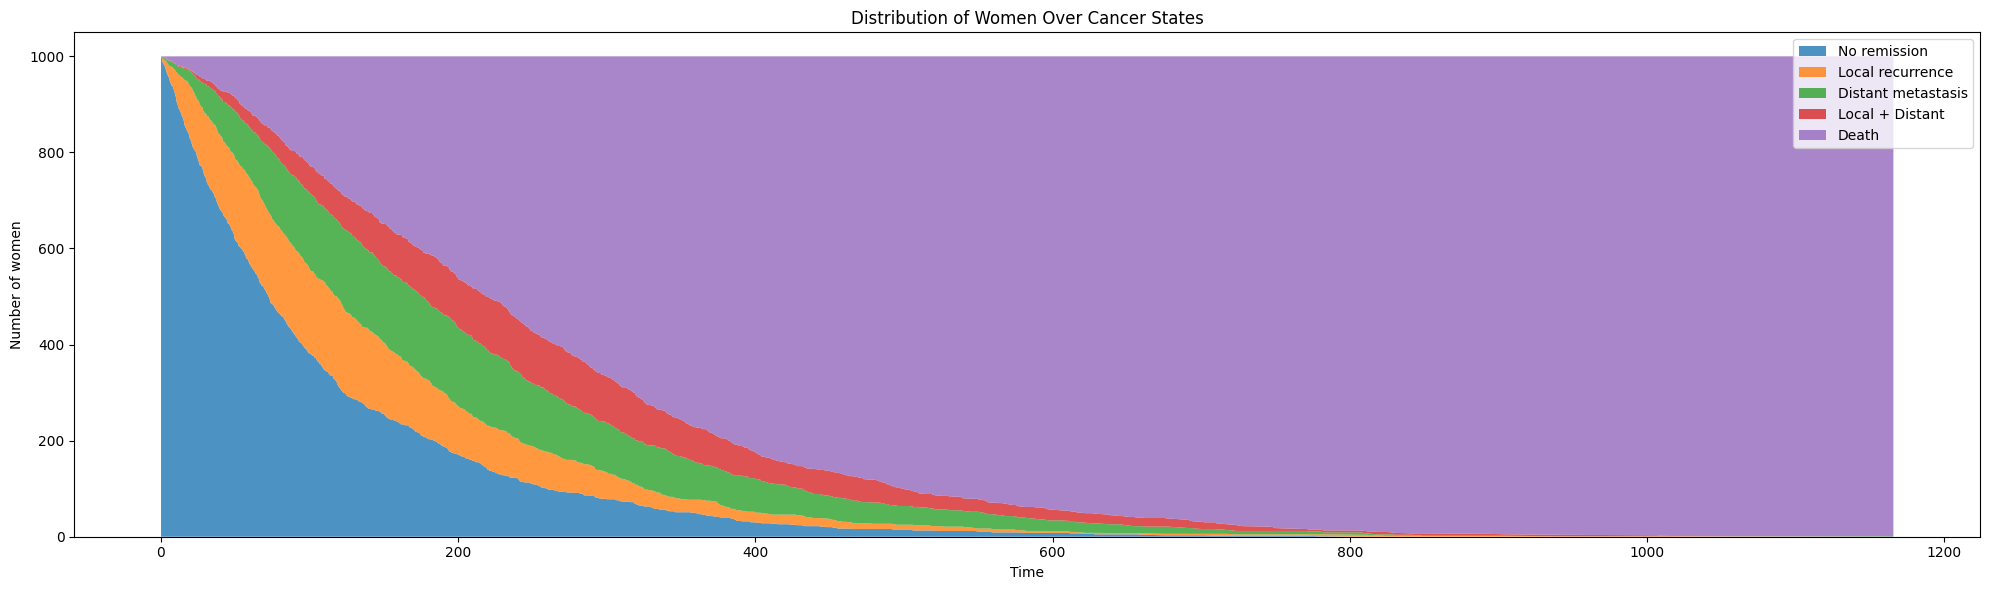

In [140]:
x = results["times"]  # Times when transitions happened
state_history = results["state_history"]  # State of all women at each event

# Count how many women are in each state at each time point
counts = np.zeros(state_history.shape)

for i, state_vector in enumerate(state_history):
    unique, count = np.unique(state_vector, return_counts=True)
    counts[i, unique] = count

# Transpose for stackplot (shape: [num_states, timepoints])
y = counts.T

# Labels for states
labels = [
    "No remission",
    "Local recurrence",
    "Distant metastasis",
    "Local + Distant",
    "Death",
]

# Plot
fig, ax = plt.subplots(figsize=(20, 6))
ax.stackplot(x, y, labels=labels, alpha=0.8)
ax.set_xlabel("Time")
ax.set_ylabel("Number of women")
ax.set_title("Distribution of Women Over Cancer States")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()
